# Facial Emotion Recognition using CNN

Data preprocessing, facial feature extraction, and facial emotion classification are the three key steps in the notebook. Facial expressions were predicted with the accuracy of <span style="color:crimson;">58.8</span> percent with using the Convolutional Neural Network (CNN). This algorithm was evaluated on a publicly available dataset from the <span style="color:crimson;">FER2013</span> database, which has 35887 48x48 grayscale face images.

**Table of contents of this notebook:**

**1.** [Importing necessary libraries](#1)

**2.** [Loading the data](#2)

**3.** [Data pre-processing](#3)

**4.** [Design a model](#4)


<h1 id="1"> <center>1. Importing necessary libraries</center> </h1> <a id="1"></a>

In [1]:
%%capture
!pip install scikit-plot

In [4]:
import pandas as pd
import numpy as np
import scikitplot
import random
import seaborn as sns
import keras
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import warnings
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.preprocessing.image import ImageDataGenerator,load_img
# from keras.utils.vis_utils import plot_model
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.simplefilter("ignore")
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
# import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

<h1 id="1"> <center>2. Loading the data</center> </h1> <a id="2"></a>

In [43]:
data = pd.read_csv("./fer2013.csv")
data.shape

(35887, 3)

To see the dataset has any missing values.

In [44]:
data.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [45]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


<h1 id="1"> <center>3. Data pre-processing</center> </h1> <a id="3"></a>

## 3.1 Shuffling the data




Firstly, we will shuffle the data using sample() function and determining fraction as 1 to shuffle the data by changing the rows.

In [46]:
data = data.sample(frac=1)

## 3.2 One Hot Encoding

Then, we will do one hot encoding operation to change the categorical labels as numeric labels to learning algorithm can work better in predictions process.

In [47]:
labels = to_categorical(data[['emotion']], num_classes=7)
labels

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Changing image pixels to Numpy array


In [48]:
train_pixels = data["pixels"].astype(str).str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)

## 3.3 Standardization

We will change the data structure to feed the standart scaler to implement standardization process to our data. Since StandartScaler() function only takes 2 dimensional array we will reshape the data then apply our scaler to make the mean zero and standart deviation as unit. 

 

In [49]:
pixels = train_pixels.reshape((35887*2304,1))

In [50]:
scaler = StandardScaler()
pixels = scaler.fit_transform(pixels)

## 3.4 Reshaping the data (48,48)


After that, we will reshape the data to make our image pixels ready to split operation. 

In [51]:
pixels = pixels.reshape((35887, 48, 48,1))

## 3.5 Train test validation split


Now, we have 35887 images with each containing 48x48 pixels. We will split the data into train,test and Validation data to feed and evaluate and validate our data with the ratio of 10%.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [53]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(29068, 48, 48, 1)
(3589, 48, 48, 1)
(3230, 48, 48, 1)


We can see some train data containing one sample of each class with the help of this plot code.

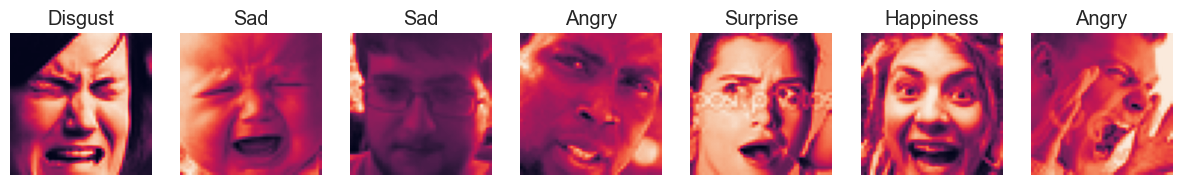

In [54]:
plt.figure(figsize=(15,23))
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
i = 1
for i in range (7):
    img = np.squeeze(X_train[i])
    plt.subplot(1,7,i+1)
    plt.imshow(img)
    index = np.argmax(y_train[i])
    plt.title(label_dict[index])
    plt.axis('off')
    i += 1
plt.show()

## 3.6 Data augmentation using ImageDataGenerator

We can do data augmentation to have more data to train and validate our model to prevent overfitting. Data augmentation can be done on training and validation sets as it helps the model become more generalize and robust.

In [55]:
datagen = ImageDataGenerator(  width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)
valgen = ImageDataGenerator(   width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2) 

In [56]:
datagen.fit(X_train)
valgen.fit(X_val)

In [57]:
train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = datagen.flow(X_val, y_val, batch_size=64)

Our dataset is ready to feed our model. We will look at our model architecture.

<h1 id="1"> <center>4.  Design a model </center> </h1> <a id="4"></a>

## 4.1 CNN model

CNN model has many layers with different units such as Convolutional layer, Max pooling layer, Batch normalization and Drop out layer to regularize the model.

In [58]:
def cnn_model():

  model= tf.keras.models.Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
  model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
      
  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten()) 
  model.add(Dense(256,activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
      
  model.add(Dense(512,activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Dense(7, activation='softmax'))
  model.compile(
    optimizer = Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
  return model

In [59]:
model = cnn_model()

Then, we compile our model with Adam optimizer with 0.0001 learning rate and chose metric as accuracy, then loss as categorical crossentropy

In [60]:
model.compile(
    optimizer = Adam(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [61]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_14 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 24, 24, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 24, 24, 128)      

## 4.2 Early stopping

Adding checkpointer to implement Early Stopping to prevent overfitting.

In [67]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 5),
                ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [ ]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=64,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/30
455/455 [==============================] - ETA: 0s - loss: 6.8887 - accuracy: 0.2139
Epoch 1: val_accuracy improved from -inf to 0.26130, saving model to best_model.h5
455/455 [==============================] - 619s 1s/step - loss: 6.8887 - accuracy: 0.2139 - val_loss: 2.5633 - val_accuracy: 0.2613
Epoch 2/30
455/455 [==============================] - ETA: 0s - loss: 2.5531 - accuracy: 0.2941
Epoch 2: val_accuracy improved from 0.26130 to 0.30062, saving model to best_model.h5
455/455 [==============================] - 573s 1s/step - loss: 2.5531 - accuracy: 0.2941 - val_loss: 2.7144 - val_accuracy: 0.3006
Epoch 3/30
455/455 [==============================] - ETA: 0s - loss: 2.6583 - accuracy: 0.4097
Epoch 3: val_accuracy improved from 0.30062 to 0.43065, saving model to best_model.h5
455/455 [==============================] - 555s 1s/step - loss: 2.6583 - accuracy: 0.4097 - val_loss: 2.7055 - val_accuracy: 0.4307
Epoch 4/30
455/455 [==============================] - ETA: 0s

## 4.3 Visualizing results

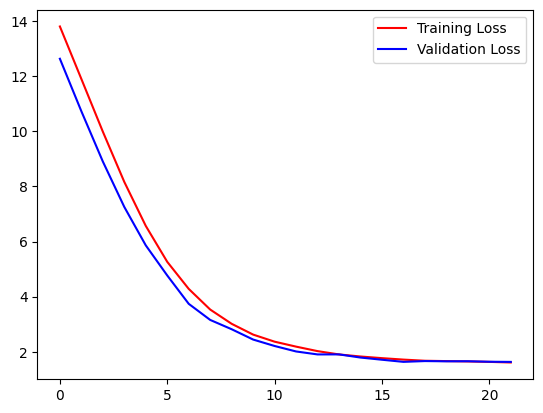

In [29]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

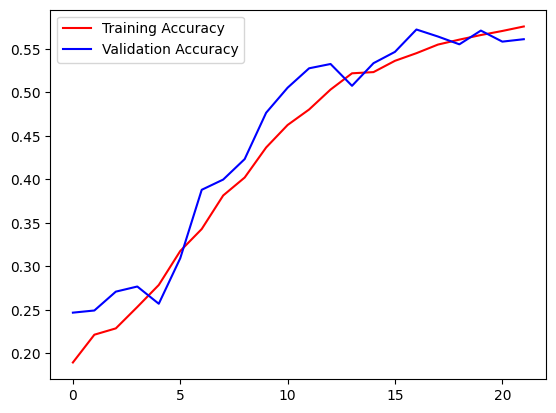

In [30]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

In [31]:
loss = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 12s 107ms/step - loss: 1.5870 - accuracy: 0.5876
Test Acc: 0.5876288414001465


In [32]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

113/113 [==============================] - 16s 139ms/step


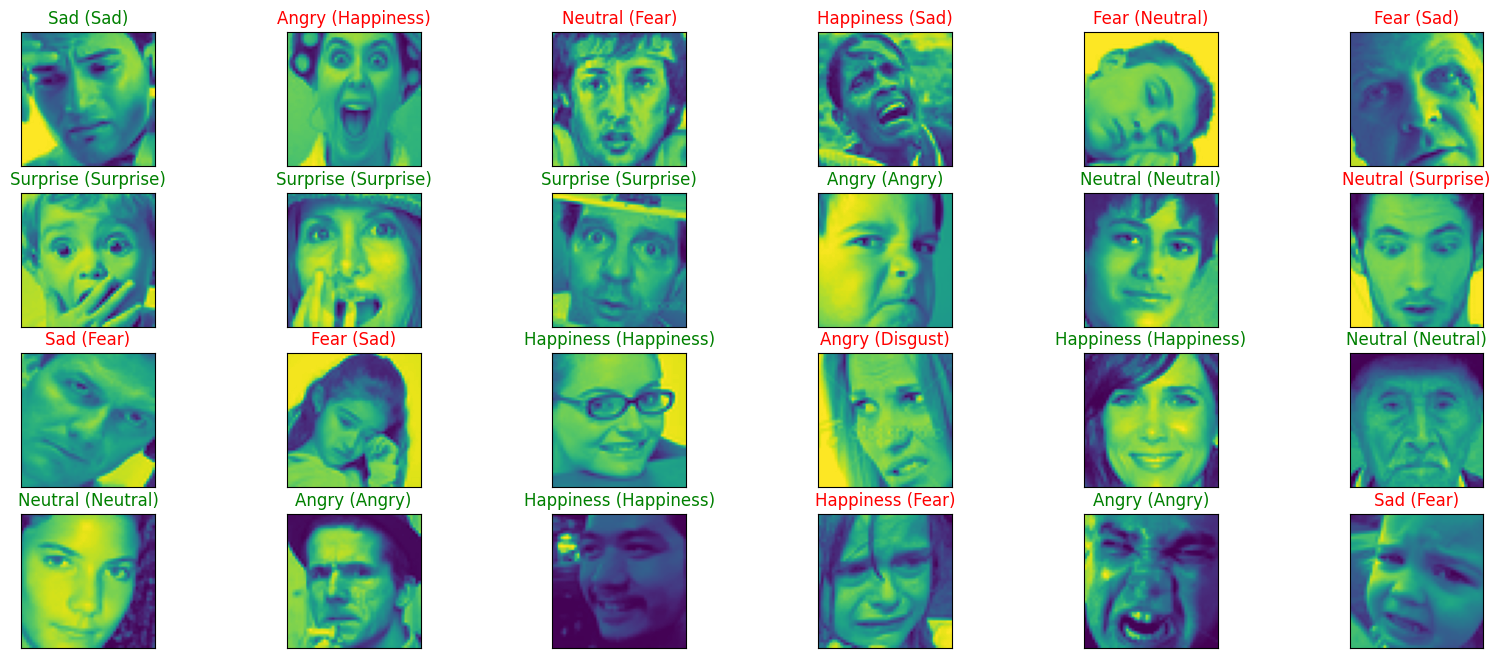

In [33]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

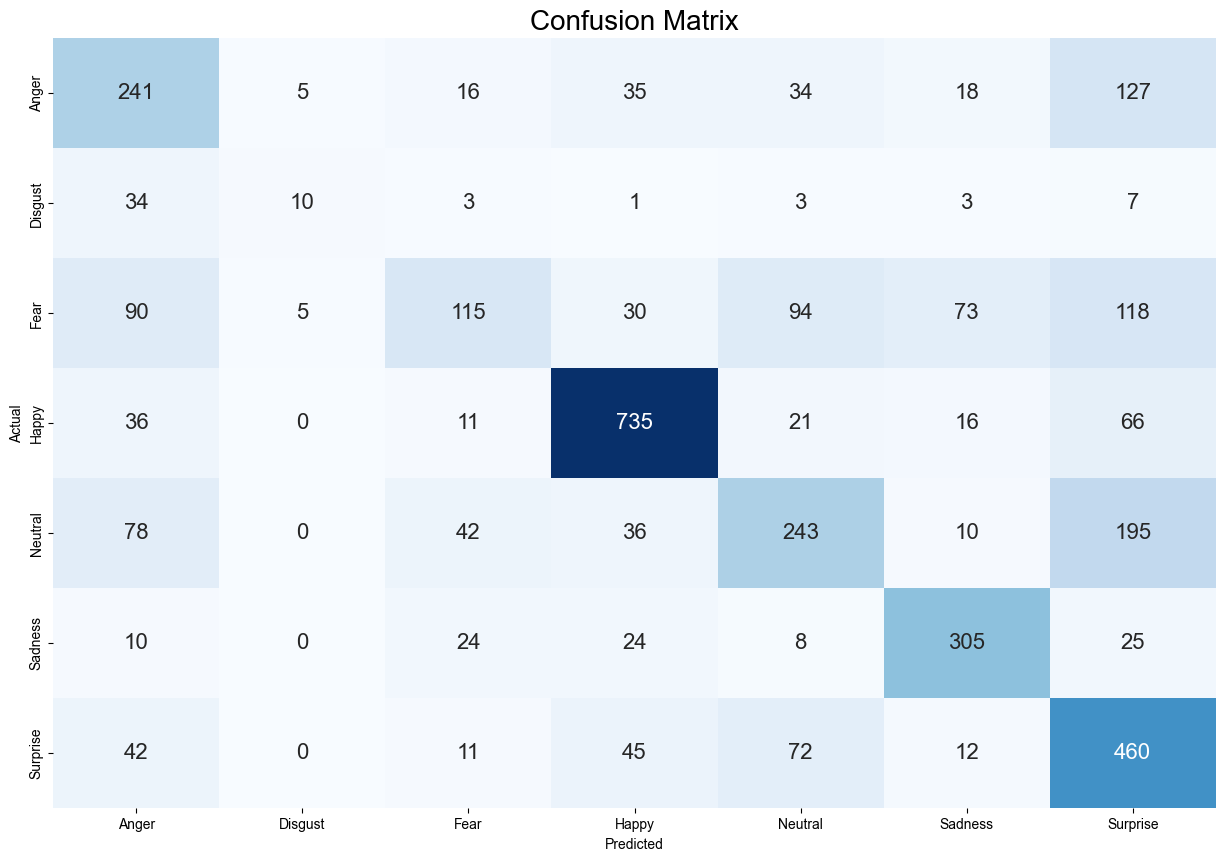

In [34]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (15,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [35]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.454     0.506     0.479       476
           1      0.500     0.164     0.247        61
           2      0.518     0.219     0.308       525
           3      0.811     0.831     0.821       885
           4      0.512     0.402     0.450       604
           5      0.698     0.770     0.732       396
           6      0.461     0.717     0.561       642

    accuracy                          0.588      3589
   macro avg      0.565     0.516     0.514      3589
weighted avg      0.590     0.588     0.572      3589



## Saving the model

In [42]:
model.save("emotion-recognition-model.h5")

In [62]:
# Save scaler for further use
from joblib import dump
dump(scaler, 'std_scaler.bin', compress=True)

['std_scaler.bin']

In [63]:
import pickle
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [64]:
scaler.mean_


array([129.38585663])

In [66]:
scaler.scale_
# scaler.transform()

array([65.0578923])